# Assignment 2: Milestone I Natural Language Processing
## Task 2&3
#### Student Name: Denzel Tan
#### Student ID: s3900098

Date: 23/09/2021

Version: 1.0

Environment: Python 3 and Jupyter notebook

Libraries used: please include all the libraries you used in your assignment, e.g.,:
* pandas
* re
* numpy

## Introduction


Denzels Note: I have tried to comment as much as essential for the code without aimlessly spamming.

Also, if you see Save CSV code, that was for the old existing function, where I saved the dataframe and re-opened it instead of training document vectors again. Thankfully, that is not needed anymore and I have commented it out.

### The Dataset

The Dataset that is being used is the pre-processed job_ads.txt we generated in task 1.

Essentially, it has **55449** entries of job advertisements, with each entry containing on each line:
1. ID
2. WebIndex
3. Category
4. Title
5. Description

We'll be working with the description mainly, but the title will be used too.

## Importing libraries 

In [1]:
# Code to import libraries as you need in this assessment, e.g.,
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import CountVectorizer
from itertools import chain
from sklearn.datasets import load_files
from nltk.probability import *

from nltk import RegexpTokenizer
from nltk.tokenize import sent_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer

# Task 2. Generating Feature Representations for Job Advertisement Descriptions

## 0. Preparing our Data

### Description

First we will open up our .txt file with all the ads and split it up into a massive list of strings, with each string being 1 line of that file, which represents the ID, Category, Webindex, Title and Decription.

In [2]:
with open("job_ads.txt",'r') as f:
    data = f.readlines()

In [3]:
data[:10]

['ID: 14624\n',
 'Category: Engineering\n',
 'Webindex: 62119057\n',
 'Title: Plant Engineer\n',
 'Description: established manufacturer supplier quality water treatment plants ranging basic water softeners reverse osmosis equipment customer complex water treatment solutions meet clients requirements flexibility tailoring product budgets due expansion increased workload seeking recruit planet engineer cover accounts corridor responsibilities include conducting routine sampling analysis water systems interpreting results maintenance installation chemical dosing systems servicing accounts industrial commercial industries complete accordance approved code practice ideal applicant minimum years relevant industry reverse osmosis water softeners water filters uv equipment full driving license return offering competitive package ideal\n',
 'ID: 31567\n',
 'Category: Healthcare_Nursing\n',
 'Webindex: 66314490\n',
 'Title: Residential Care Worker\n',
 'Description: timeout children homes rapid

In [4]:
# Test to see if we can extract the description
re.findall(r'Description: (.+)\n',data[4])

['established manufacturer supplier quality water treatment plants ranging basic water softeners reverse osmosis equipment customer complex water treatment solutions meet clients requirements flexibility tailoring product budgets due expansion increased workload seeking recruit planet engineer cover accounts corridor responsibilities include conducting routine sampling analysis water systems interpreting results maintenance installation chemical dosing systems servicing accounts industrial commercial industries complete accordance approved code practice ideal applicant minimum years relevant industry reverse osmosis water softeners water filters uv equipment full driving license return offering competitive package ideal']

In [5]:
# Saving the descriptions to a list

des_raw = []
for i in range(4,len(data),5): # Iterating thru list of data, selecting every 5th one.
                                # This is because the description is on every 5th line. Starting from index 4.
    des_raw.append(re.findall(r'Description: (.+)\n*',data[i]))# Once done, use regex to extract the description out only
    # Then save to a list.
len(des_raw)

55449

Also, we should flatten the list, meaning convert it from list of list of string, to list of strings!

In [6]:
# Flattening the list
des = list(chain.from_iterable(des_raw))
len(des)

55449

Nice. So we managed to extract out our descriptions from the text file we made in Task 1.

### Vocab

In [7]:
# Open up the Vocab file we saved earlier
with open('vocab.txt','r') as f:
    raw_vocab = f.readlines()

In [8]:
# test to extract the word only.
raw_vocab[0].split(':')[0]

"a'level"

In [9]:
# Extracting the vocab only, not the index of it.
vocab = []
for i in range(0,len(raw_vocab)):
    vocab.append(raw_vocab[i].split(':')[0])

In [10]:
# Checking
print(len(vocab))
vocab[:5]

40144


["a'level", 'aa', 'aaa', 'aaappointments', 'aab']

Yup thats correct, as the length of our vocab is 40144 by checking the file manually.


### WebIndex

Lets extract our Webindex now.

In [11]:
# Test to extract the webindex
print(data[2])
re.findall(r'Webindex: (\d+)\n',data[2])

Webindex: 62119057



['62119057']

In [12]:
# Now applying to entire list
webindex_list_raw = []
for i in range(2,len(data),5):
    webindex_list_raw.append(re.findall(r'Webindex: (\d+)\n',data[i]))
webindex_list_raw[0]

['62119057']

In [13]:
webindex_list = list(chain.from_iterable(webindex_list_raw))
webindex_list

['62119057',
 '66314490',
 '69182387',
 '64752715',
 '71792012',
 '70612741',
 '46628810',
 '69172722',
 '68807434',
 '72479636',
 '68092333',
 '72229719',
 '70763910',
 '72578110',
 '70759896',
 '69159371',
 '69560135',
 '66886072',
 '68608673',
 '71876246',
 '70090376',
 '68181520',
 '64558781',
 '67896016',
 '72234849',
 '66426156',
 '66952145',
 '69043129',
 '72230002',
 '68691070',
 '67770759',
 '71357143',
 '70761594',
 '66507219',
 '69182211',
 '66543099',
 '70783118',
 '69868209',
 '71444351',
 '68710342',
 '46626860',
 '70780874',
 '69470916',
 '71482344',
 '71435250',
 '69183409',
 '68834497',
 '68806742',
 '72239601',
 '70735413',
 '70782077',
 '66932685',
 '51061170',
 '65184188',
 '70078924',
 '66626362',
 '71290919',
 '69689660',
 '67755530',
 '69039153',
 '70761124',
 '67381906',
 '68215155',
 '71619334',
 '69763259',
 '72439441',
 '68627615',
 '68628765',
 '66930750',
 '68677600',
 '71226442',
 '58966613',
 '68686262',
 '72248299',
 '70682968',
 '71686197',
 '70607592',

## 1. Building our Count Vector

We will be testing the "bag of words" model for word embedding, and we will be using the Count vector to represent that. 

In [14]:
des[0]

'established manufacturer supplier quality water treatment plants ranging basic water softeners reverse osmosis equipment customer complex water treatment solutions meet clients requirements flexibility tailoring product budgets due expansion increased workload seeking recruit planet engineer cover accounts corridor responsibilities include conducting routine sampling analysis water systems interpreting results maintenance installation chemical dosing systems servicing accounts industrial commercial industries complete accordance approved code practice ideal applicant minimum years relevant industry reverse osmosis water softeners water filters uv equipment full driving license return offering competitive package ideal'

In [15]:
# Initialize the count vectorizer
# We manually set it to our own vocabulary
cVec = CountVectorizer(analyzer = "word", vocabulary = vocab)

In [16]:
# This is where the count vectorizing occurs
count_features = cVec.fit_transform([text for text in des])
count_features.shape

(55449, 40144)

In [17]:
# Count vector for all the words in the 1st job description.
print(count_features[0])

  (0, 225)	1
  (0, 246)	2
  (0, 1362)	1
  (0, 1706)	1
  (0, 1787)	1
  (0, 3010)	1
  (0, 4543)	1
  (0, 6010)	1
  (0, 6480)	1
  (0, 6705)	1
  (0, 6953)	1
  (0, 7110)	1
  (0, 7136)	1
  (0, 7150)	1
  (0, 7326)	1
  (0, 7880)	1
  (0, 8036)	1
  (0, 8599)	1
  (0, 10462)	1
  (0, 10640)	1
  (0, 10730)	1
  (0, 11723)	1
  (0, 12041)	2
  (0, 12213)	1
  (0, 12609)	1
  :	:
  (0, 27747)	1
  (0, 28277)	1
  (0, 28969)	1
  (0, 29221)	1
  (0, 29613)	1
  (0, 30044)	1
  (0, 30355)	1
  (0, 30519)	1
  (0, 30594)	1
  (0, 30657)	1
  (0, 30687)	2
  (0, 31273)	1
  (0, 31647)	1
  (0, 32161)	1
  (0, 32488)	1
  (0, 33475)	2
  (0, 33562)	1
  (0, 35047)	1
  (0, 35387)	2
  (0, 35459)	1
  (0, 36967)	2
  (0, 37930)	1
  (0, 38783)	6
  (0, 39608)	1
  (0, 39961)	1


In [18]:
# Lets validate with vocab 246, which is "accounts"
# As you can see, the word occurs twice in here. Hence, 
print(vocab[246])
re.findall(r'accounts',des[0])

accounts


['accounts', 'accounts']

Ok we got the count vectors working!

We will save them to the desired format at the end!

## 2. FastText Language Model

With FastText, we will be training our own model with a corpus of all our description texts.

Note: Pre-Trained FastText models do exist, but we will be training our own today.

In [19]:
# Importing FastText
from gensim.models.fasttext import FastText

#### 2.1 Training the model to our Data first

In [20]:
# Making our corpus
out_file = open('jobstext.txt', 'w') # creates a txt file and open to save the ads
out_file.write("\n".join([text for text in des])) # Write the content
out_file.close() # close the file

We made a text file of JUST the descriptions all togather.

In [21]:
# 1. Initialise the Fast Text model; We use 300 dimensions, for consistency with the rest of our data.
jobsFT = FastText(vector_size = 300)

# 2. build the vocabulary
jobsFT.build_vocab(corpus_file = './jobstext.txt')

# 3. train the model
jobsFT.train(corpus_file='./jobstext.txt',epochs=jobsFT.epochs,
             total_examples=jobsFT.corpus_count, total_words=jobsFT.corpus_total_words)

print(jobsFT)

FastText(vocab=22850, vector_size=300, alpha=0.025)


In [22]:
# Checking Datatype of word vector
wv_jobsFT = jobsFT.wv
print(wv_jobsFT)

In [23]:
# Test if word is in the vocab, since any word can be vectorized when using FastText.
'google' in wv_jobsFT.key_to_index

True

In [24]:
# Validated document vector working
wv_jobsFT['google']

array([ 1.5223496 ,  0.3057584 , -0.3266933 ,  0.2545394 , -0.7723785 ,
       -1.4069523 , -0.3282104 , -0.22007532, -0.29207954, -0.1635981 ,
       -0.58370376, -1.6128416 , -0.46492782, -1.5485432 ,  0.00518159,
       -0.04202797,  0.12654248,  0.52598375,  0.39136487, -0.7607249 ,
        0.5256811 , -0.49951217,  1.154847  , -0.15446469,  0.8875018 ,
       -0.0983033 ,  0.6255971 , -0.22692786, -1.4912708 ,  0.3446806 ,
        0.8496426 ,  0.44979706,  0.5854221 , -0.4844771 , -1.1429988 ,
        0.717367  ,  0.5374929 ,  0.01319729,  0.46961522, -0.81766206,
        0.02318356,  1.1307642 , -0.61786795,  0.6083195 ,  1.1011134 ,
        0.11595392, -0.08287309,  0.05246282,  1.682432  ,  0.7366857 ,
        1.489205  , -0.8185753 , -0.17372175,  0.21072629, -0.7130102 ,
        1.6234417 , -0.66681886,  1.5752827 , -0.03733751,  0.3464616 ,
       -0.8849438 ,  0.6322844 , -1.6173329 ,  1.4064441 , -0.31728995,
        0.6613721 ,  0.12246425, -1.0763966 , -1.0199398 ,  0.25

In [25]:
# Number of "dimensions" each word has in terms of vectors
len(wv_jobsFT['google'])

300

Notice how the length of word vectors (our vocab; 22850) is of different length to the vocab we made in Task1 (40144). This is because FastText does its own "auto-tokenization" which have different standards to our preprocessing, so it actually does some more of its own cleaning, before it converts each word to a vector.

### 2.2 Generate document embeddings based on the trained word embeddings


Ok dude what you have to do now is tokenize each description, then apply the FastText model on the tokens to generate a vector for each whole decription itself.

#### Lets tokenize first. We'll just tokenize by splitting.

In [26]:
# TOKENIZING every job description and storing it
# Note: We don't need any preprocessing in tokenizing because we already pre-preprocessed the text.
destk = [text.split(' ') for text in des]

Now lets put it in our Document Vectorizer.

Basically, what this function does is iterate thru every word, and finds the vector representation of that word (which is an array of 300 numbers). It then adds up the vector representations (all 300 numbers) of all the words in that document. Then the end result is an array of 300 numbers which is the document vector. It does this for every single document.

#### Note: I'll be using my altered gen_docVecs2 function to document vectorize due to speed issues with the original.

It does exactly the same thing, except all the processing is done with an array/list instead of using a DataFrame in the calculations, which can be extremely slow.

Then at the end, it is converted into a DataFrame once all the processing is done.

Old: ~1.5 hr

New: ~2-4 min

In [27]:
def gen_docVecs2(wv,tk_txts): # generate vector representation for documents 2.0 Improved Denzel Tan version
    
    doc_vector = []
    for i in range(0,len(tk_txts)): # for each tokenized article
        tokens = tk_txts[i]
        summed = 0 # Initialize the array, even with a int.
        
        for w_ind in range(0, len(tokens)): # for each word in that article
            try:
                word = tokens[w_ind] # getting individual token
                word_vec = wv[word]  # getting the word vector
                summed = summed + word_vec # adding all the vectors togather. 
                # So end result is still 1x300 for a document.
            except:
                pass
        doc_vector.append(list(summed)) # Compile all 55449 document vectors into a big list. Now 55449x300
    docs_vectors = pd.DataFrame(doc_vector) # Convert that list into a DataFrame
    return docs_vectors

### 2.3 FastText

In [28]:
# FAST TEXT DOCUMENT VECTORIZING

# NOTE this can take some time to finish running EDIT: Not anymore!

dv_FT = gen_docVecs2(wv_jobsFT,destk)
dv_FT.isna().any().sum() # check whether there is any null values in the document vectors dataframe.

0

In [29]:
# Read CSV with the data. Save time no need to re-train.
#dv_FT = pd.read_csv('dv_FastText.csv')
#dv_FT

In [30]:
# Wow that took like 1hr 15min.
# Saving to a CSV so that we can reimport the DF if needed without re-training.

#dv_FT.to_csv('dv_FastText.csv',index = False)

## 3. GoogleNews300 (Pre-Trained)

In [31]:
# loading the pre-trained word2vec model based on google news

import gensim.downloader as api
wv_GN300 = api.load('word2vec-google-news-300')

#### Google News

In [32]:
# GOOGLE NEWS DOCUMENT VECTORIZING

# NOTE this can take some time to finish running
dv_GN300 = gen_docVecs2(wv_GN300,destk)
dv_GN300.isna().any().sum() # check whether there is any null values in the document vectors dataframe.

0

In [33]:
# Saving to a CSV 
#dv_GN300.to_csv('dv_GN300.csv',index = False)

In [34]:
#dv_GN300 = pd.read_csv('dv_GN300.csv')
dv_GN300

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,-4.546768,5.067924,2.481800,2.889145,-5.867694,1.922361,1.819260,-5.643738,3.034363,2.692574,...,-6.215942,2.623596,-4.843262,4.526443,0.330536,0.752022,-0.174652,-0.364319,4.098686,-3.404217
1,-0.872101,0.557505,-0.474548,4.512268,-2.706406,-0.602787,3.192154,-3.002121,4.646362,-4.292419,...,-3.955048,1.782196,-7.212727,-0.014885,-0.591583,1.429382,0.405249,-1.993744,1.269203,-0.962341
2,-3.478378,1.442741,-1.097778,4.933929,-1.868793,1.896019,-0.223526,-5.567322,3.622606,2.308132,...,-2.116924,2.591629,-3.594101,2.625061,0.972580,-1.445465,0.002319,-1.612640,0.562153,-2.285095
3,-3.872299,2.042828,0.468018,0.002045,-2.529800,0.126999,1.607147,-4.834270,5.598373,-3.731567,...,-3.095764,1.786911,-3.837097,3.178623,-1.668671,1.535706,-0.629822,-0.707443,3.304611,1.170349
4,-2.315674,0.330042,0.247406,1.883667,-1.592896,-1.544556,2.662231,-4.661743,3.335389,-0.686310,...,-3.004673,2.648071,-3.676279,0.199734,2.657959,-0.829605,1.010836,-3.689674,-0.146606,-1.210449
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55444,-6.506058,3.951706,-3.012321,-0.288738,-4.345215,-0.263962,7.712452,-4.252290,12.016479,-5.474796,...,-6.736755,0.269592,-4.959473,4.934784,-0.702740,-2.777893,3.173286,-4.769787,-1.469242,-1.643982
55445,-4.608643,3.788315,2.073846,6.964081,-1.779922,0.394180,4.353258,-9.971779,2.855761,-0.319389,...,-7.036392,1.292145,-8.732117,2.265808,-1.088470,-0.143787,2.769424,-5.193970,1.236752,1.455404
55446,-1.948257,3.651352,-0.931793,3.458700,-2.773972,0.513422,6.540438,-9.362244,9.024445,7.087097,...,-5.781281,6.218760,-7.490662,5.271879,-0.653503,4.420265,1.882524,2.110634,-1.248695,-5.211304
55447,-1.164276,1.451782,-1.223419,0.404083,-0.152405,1.391483,2.597244,-2.492096,4.274567,1.205307,...,-1.685394,2.294662,-3.658966,3.524780,1.103916,-0.114914,0.465881,-3.771881,-2.067268,-0.874908


## 4. GLOVE (Pre-Trained)

In [35]:
# Importing the 300 dimension GLOVE file

import utils
from utils import loadGloVe

fPath = "/Users/denzelo/Documents/UNIVERSITY/Code Notebooks/Week8_Act4_Document Classification/glove/glove.6B.300d.txt"
wv_GLOVE = loadGloVe(fPath) # load the GloVe embeddings

Found 400000 word vectors.


In [36]:
# NOTE this can take some time to finish running
dv_GLOVE = gen_docVecs2(wv_GLOVE,destk)
dv_GLOVE.isna().any().sum() # check whether there is any null values in the document vectors dataframe.

0

In [37]:
#dv_GLOVE = pd.read_csv('dv_GLOVE.csv')
dv_GLOVE

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,-2.197354,1.159163,1.236320,-15.670534,-3.212329,3.253896,12.625774,7.933493,-0.488338,-110.931480,...,-10.260087,-4.458088,-3.170978,-4.364176,14.537739,13.845961,-3.752656,-17.961893,1.204020,-1.947374
1,-11.338754,3.071290,2.499938,-0.238676,1.322273,2.749740,-0.312054,-1.606071,-1.928115,-62.453117,...,-5.995009,-14.628064,-2.519705,-8.622393,3.736048,1.116887,-3.072000,-3.590593,0.094523,-8.809059
2,-1.283338,3.844718,4.585536,-1.154910,-3.496203,0.854106,-1.128256,0.080987,-0.285871,-64.099998,...,2.419956,-7.245219,-12.636186,-0.450910,6.754822,10.026826,-1.600276,-9.540119,-7.069987,-4.622457
3,-15.673364,2.360960,2.890041,0.787373,1.128022,-5.840070,3.639604,-2.180736,-2.237748,-74.391487,...,-6.951455,-11.472593,-6.857063,-15.906814,2.191053,15.034398,-2.184544,-7.013738,-8.054841,2.145760
4,-8.312830,-1.811682,2.042164,-1.695956,-1.078097,-3.168170,0.111690,-0.625563,0.489268,-52.720989,...,0.513880,-3.609222,-4.955360,-5.315103,2.652804,12.972917,-5.114026,-8.078370,-5.827615,2.516729
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55444,-21.998177,14.223733,6.487310,-10.851713,-3.726549,1.100680,-8.021920,17.114012,2.548543,-180.336304,...,-16.389908,-14.147321,-24.988092,-6.654264,8.967227,29.506948,-11.991526,-9.860179,-13.724459,-15.702429
55445,-16.940619,3.647862,2.923049,-0.547759,-3.742514,-5.296058,6.879586,0.057168,-7.824692,-109.340446,...,-15.321952,-7.266719,-22.308458,-7.815048,10.747326,16.510254,-4.514823,-24.685869,-6.620125,-8.038265
55446,-10.593685,11.755412,-0.437208,-8.585835,-0.319387,-2.844864,-2.056523,7.789015,-6.605925,-121.169678,...,-6.426315,-12.866957,-17.894350,0.661959,16.421560,41.729897,-11.056681,-7.279248,-11.234014,-6.636180
55447,-4.572896,0.565808,9.485980,-0.885506,0.994985,-1.689959,7.887112,7.182546,-5.109086,-49.352623,...,3.452804,1.083090,-0.935546,-5.154752,7.778006,9.958865,-2.052572,-2.158738,-4.067009,-5.338408


In [38]:
#Saving to a CSV 
#dv_GLOVE.to_csv('dv_GLOVE.csv',index = False)

# TF IDF Weighted Document Vectors

Now we will create document vectors for all 3 word embedding models (FastText, GoogleNews300, GLOVE), but this time we will apply a TF-IDF weighting to each words vector representation.

#### Preperation 

In [39]:
# Preparing what we need
from sklearn.feature_extraction.text import TfidfVectorizer
tVectorizer = TfidfVectorizer(analyzer = "word",vocabulary = vocab) # initialised the TfidfVectorizer
tfidf_features = tVectorizer.fit_transform([' '.join(text) for text in destk]) # generate the tfidf vector representation for all articles
tfidf_features.shape

(55449, 40144)

Lets define the functions needed first.

Here, we once again alter the original function (for the tf-idf) to utilize an array instead of a dataframe during processing, THEN finally convert to dataframe form at the end. This is for speed.

In [40]:
def gen_tf_docVecs2(wv,tk_txts,tfidf = []): # generate vector representation for documents with TF-idf weighting
    
    doc_vector = []
    for i in range(0,len(tk_txts)): # for each tokenized article
        tokens = list(set(tk_txts[i])) # getting all unique tokens, as repeated tokens are already factored in with TF-IDF weighting
        summed = 0
        
        for w_ind in range(0, len(tokens)): # for each word in that article
            try:
                word = tokens[w_ind]
                word_vec = wv[word]  # getting the word vector
                
                if tfidf != []: # Checking if said word exists in tf-idf weighting list
                    word_weight = float(tfidf[i][word]) # If it does, capture the word weight
                else:
                    word_weight = 1 # If it doesn't, just make it 1
                    
                weighted_word_vec = word_vec*word_weight # applying the word weight
                summed = summed + weighted_word_vec # adding up all word vectors into that specific document vector
            except:
                pass
        doc_vector.append(list(summed)) # appending said document vector to a list (of all document vectors)
    docs_vectors = pd.DataFrame(doc_vector) # Convert to DataFrame
    return docs_vectors

In [41]:
# Writing our TF-IDF vector file (for use with the function above)
def write_vectorFile(data_features,filename):
    num = data_features.shape[0] # the number of document
    out_file = open(filename, 'w') # creates a txt file and open to save the vector representation
    for a_ind in range(0, num): # loop through each article by index
        for f_ind in data_features[a_ind].nonzero()[1]: # for each word index that has non-zero entry in the data_feature
            value = data_features[a_ind][0,f_ind] # retrieve the value of the entry from data_features
            out_file.write("{}:{} ".format(f_ind,value)) # write the entry to the file in the format of word_index:value
        out_file.write('\n') # start a new line after each article
    out_file.close() # close the file

In [42]:
write_vectorFile(tfidf_features,'./TFIDF vectorzzz.txt') # write the tfidf vector to file

In [43]:
# Creating a dictionary of the vocabulary and its index. 

# We can use our existing vocab list, and just select out the index and word into a dictionary

def gen_vocIndex(voc_fname):
    with open(voc_fname) as vocf: 
        voc_Ind = [l.split(':') for l in vocf.read().splitlines()] # each line should be 'index,word'
    return {int(vi[1]):vi[0] for vi in voc_Ind} # is [1] and [0] because the order is reversed in our vocab list


# Generates the w_index:word dictionary
voc_fname = './vocab.txt' # path for the vocabulary
voc_dict = gen_vocIndex(voc_fname)
voc_dict

{0: "a'level",
 1: 'aa',
 2: 'aaa',
 3: 'aaappointments',
 4: 'aab',
 5: 'aac',
 6: 'aacc',
 7: 'aae',
 8: 'aah',
 9: 'aak',
 10: 'aamm',
 11: 'aan',
 12: 'aand',
 13: 'aantrekkelijk',
 14: 'aap',
 15: 'aar',
 16: 'aarca',
 17: 'aardman',
 18: 'aareon',
 19: 'aaron',
 20: 'aaronwallis',
 21: 'aarosette',
 22: 'aarosettehotel',
 23: 'aarosettelivein',
 24: 'aarosetterestaurant',
 25: 'aarosetterestaurantlondon',
 26: 'aarosettes',
 27: 'aarosettesinternationalchainofhotels',
 28: 'aarosetteslivein',
 29: 'aasl',
 30: 'aasp',
 31: 'aastra',
 32: 'aat',
 33: 'aatom',
 34: 'ab',
 35: 'aba',
 36: 'abacus',
 37: 'abaility',
 38: 'abandoned',
 39: 'abandonment',
 40: 'abandons',
 41: 'abap',
 42: 'abaqus',
 43: 'abatement',
 44: 'abb',
 45: 'abbas',
 46: 'abbey',
 47: 'abbeywood',
 48: 'abbie',
 49: 'abbot',
 50: 'abbots',
 51: 'abbott',
 52: 'abby',
 53: 'abbyy',
 54: 'abc',
 55: 'abd',
 56: 'abdo',
 57: 'abdominal',
 58: 'abdul',
 59: 'abdulla',
 60: 'abel',
 61: 'abellprotocoleducation',
 

In [44]:
# making a dictionary to store the word weights of documents
def doc_wordweights(fName_tVectors, voc_dict):
    tfidf_weights = [] # a list to store the  word:weight dictionaries of documents
    
    with open(fName_tVectors) as tVecf: 
        tVectors = tVecf.read().splitlines() # each line is a tfidf vector representation of a document in string format 'word_index:weight word_index:weight .......'
    for tv in tVectors: # for each tfidf document vector
        tv = tv.strip()
        weights = tv.split(' ') # list of 'word_index:weight' entries
        weights = [w.split(':') for w in weights] # change the format of weight to a list of '[word_index,weight]' entries
        wordweight_dict = {voc_dict[int(w[0])]:w[1] for w in weights} # construct the weight dictionary, where each entry is 'word:weight'
        tfidf_weights.append(wordweight_dict) 
    return tfidf_weights

fName_tVectors = './TFIDF vectorzzz.txt'
tfidf_weights = doc_wordweights(fName_tVectors, voc_dict)

Ok we are done preparing all we need. Lets Vectorize.

------

#### Document Vectorizing 

FastText

In [45]:
# Making weighted Document Vector
weighted_FT_dvs = gen_tf_docVecs2(wv_jobsFT,destk,tfidf_weights)

# Saving to a CSV 
#weighted_FT_dvs.to_csv('dv_FT_weighted.csv',index = False)

Google News 300

In [46]:
# Making weighted Document Vector
weighted_Google_dvs = gen_tf_docVecs2(wv_GN300,destk,tfidf_weights)

# Saving to a CSV 
#weighted_Google_dvs.to_csv('dv_GN300_weighted.csv',index = False)

GLOVE

In [47]:
# Making weighted Document Vector
weighted_GLOVE_dvs = gen_tf_docVecs2(wv_GLOVE,destk,tfidf_weights)

# Saving to a CSV 
#weighted_GLOVE_dvs.to_csv('dv_GLOVE_weighted.csv',index = False)

In [48]:
# This was for reading from csv, back when the document vectors took hours to process.

#weighted_FT_dvs = pd.read_csv('dv_FT_weighted.csv')
#weighted_Google_dvs = pd.read_csv('dv_GN300_weighted.csv')
#weighted_GLOVE_dvs = pd.read_csv('dv_GLOVE_weighted.csv')

### Saving outputs
Save the count vector representation as per spectification.
- count_vectors.txt

#### Exploring the count_features

In [49]:
count_features[0]

<1x40144 sparse matrix of type '<class 'numpy.int64'>'
	with 71 stored elements in Compressed Sparse Row format>

In [50]:
type(count_features)

scipy.sparse.csr.csr_matrix

In [51]:
count_features

<55449x40144 sparse matrix of type '<class 'numpy.int64'>'
	with 4745957 stored elements in Compressed Sparse Row format>

To access this sparse matrix, we have to use the .nonzero() method.

In [52]:
count_features[0].nonzero()[1]

array([  225,   246,  1362,  1706,  1787,  3010,  4543,  6010,  6480,
        6705,  6953,  7110,  7136,  7150,  7326,  7880,  8036,  8599,
       10462, 10640, 10730, 11723, 12041, 12213, 12609, 13402, 13651,
       14272, 17144, 17523, 17555, 17646, 17653, 17655, 18005, 18245,
       20466, 21343, 21555, 22168, 22681, 25011, 25707, 25995, 27171,
       27190, 27747, 28277, 28969, 29221, 29613, 30044, 30355, 30519,
       30594, 30657, 30687, 31273, 31647, 32161, 32488, 33475, 33562,
       35047, 35387, 35459, 36967, 37930, 38783, 39608, 39961],
      dtype=int32)

Above is all the index's of the unique vocab in the 1st description (which is index 0 des)

This is how we access the count of that word (via the index) in the description:

In [53]:
print(count_features)

  (0, 225)	1
  (0, 246)	2
  (0, 1362)	1
  (0, 1706)	1
  (0, 1787)	1
  (0, 3010)	1
  (0, 4543)	1
  (0, 6010)	1
  (0, 6480)	1
  (0, 6705)	1
  (0, 6953)	1
  (0, 7110)	1
  (0, 7136)	1
  (0, 7150)	1
  (0, 7326)	1
  (0, 7880)	1
  (0, 8036)	1
  (0, 8599)	1
  (0, 10462)	1
  (0, 10640)	1
  (0, 10730)	1
  (0, 11723)	1
  (0, 12041)	2
  (0, 12213)	1
  (0, 12609)	1
  :	:
  (55448, 21360)	1
  (55448, 21478)	2
  (55448, 21781)	1
  (55448, 24561)	1
  (55448, 24688)	1
  (55448, 26413)	3
  (55448, 26414)	1
  (55448, 26677)	1
  (55448, 27257)	1
  (55448, 28240)	1
  (55448, 28244)	1
  (55448, 29492)	1
  (55448, 29753)	1
  (55448, 30073)	1
  (55448, 30497)	1
  (55448, 32351)	1
  (55448, 33757)	1
  (55448, 33801)	1
  (55448, 34180)	1
  (55448, 34261)	1
  (55448, 35845)	1
  (55448, 36655)	1
  (55448, 36924)	1
  (55448, 37946)	1
  (55448, 38500)	1


In [54]:
print(count_features[0][0,246])
vocab[246]

2


'accounts'

So this means that the word "acccount" appears twice in the 1st job description.

Lets create a function to write it in a format we want!

#### Saving

In [55]:
def write_countFeatures(data_features,filename): # Function that stores the count vector of each word for each description.
    num = data_features.shape[0] # the number of document
    out_file = open(filename, 'w') # creates a txt file and open to save the vector representation
    for a_ind in range(0, num): # for each job des
        
        out_file.write('#{}'.format(webindex_list[a_ind])) # Write the webindex of that job des
        
        for f_ind in data_features[a_ind].nonzero()[1]: # for each word that has non-zero entry in the data_feature
            value = data_features[a_ind][0,f_ind] # retrieve THAT value of the entry from data_features
            
            out_file.write(",{}:{}".format(f_ind,value)) # write the entry to the file in the format of word_index:value
        out_file.write('\n') # start a new line after each article
    out_file.close() # close the file

In [56]:
write_countFeatures(count_features,'count_vectors.txt')

Done.

# Task 3. Job Advertisement Classification

We will be using Classification today. This is a form of supervised machine learning, where our ML will have access to past data and outcomes for training. It will then be applied to test data, and compared against the correct answers to evaluate the performance.

To even start Classification, we need to set up appropriately.

### 3.1 Extract required info

Extracting the categories (what we are trying to predict)

In [57]:
# The Category info is stored on index 1 and every 5 indexes after that.
data[1]

'Category: Engineering\n'

In [58]:
# Test to pull out the Category
re.findall(r'Category: (.+)\n',data[1])

['Engineering']

In [59]:
# Creating a list of all the categories
category_list_raw = []
for i in range(1,len(data),5):
    category_list_raw.append(re.findall(r'Category: (.+)\n',data[i]))

In [60]:
# Flattening the list of lists
category_list = list(chain.from_iterable(category_list_raw))

In [61]:
# Put into DataFrame
df = pd.DataFrame(category_list,columns = ['Category'])

### 3.2 Understanding our Task and Data (with 2.D graphical Representations)

We will need 2 different functions for Visualizing both our B.O.W model and our other Vector Word Embeddings

#### Word Embedding Function

In [62]:
# TSNE function for Word Embedding (ie FastText, GN300, GLOVE)

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
def plotTSNE(labels,features): # features as a numpy array, each element of the array is the document embedding of an article
    categories = sorted(labels.unique())
    # Sampling a subset of our dataset because t-SNE is computationally expensive
    SAMPLE_SIZE = int(len(features) * 0.3)
    np.random.seed(0)
    indices = np.random.choice(range(len(features)), size=SAMPLE_SIZE, replace=False)
    projected_features = TSNE(n_components=2, random_state=0).fit_transform(features[indices])
    colors = ['pink', 'green', 'midnightblue', 'orange', 'darkgrey','salmon','aquamarine','red']
    for i in range(0,len(categories)):
        points = projected_features[(labels[indices] == categories[i])]
        plt.scatter(points[:, 0], points[:, 1], s=30, c=colors[i], label=categories[i])
    plt.title("Feature vector for each article, projected on 2 dimensions.",
              fontdict=dict(fontsize=15))
    plt.legend()
    plt.show()

#### B.O.W Function

Because count_features is a sparse matrix, we cannot use len() to get 55449. Hence we have to use .shape[0] to get it.

So `len(features)` was replaced by `features.shape[0]`.

This was the only change in the function for doing count vectors.

In [63]:
# TSNE function for Count Vectors

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

def plotTSNE_count(labels,features): # features as a numpy array, each element of the array is the document embedding of an article
    categories = sorted(labels.unique())
    # Sampling a subset of our dataset because t-SNE is computationally expensive
    SAMPLE_SIZE = int(features.shape[0] * 0.1)
    np.random.seed(0)
    indices = np.random.choice(range(features.shape[0]), size=SAMPLE_SIZE, replace=False) 
    projected_features = TSNE(n_components=2, random_state=0).fit_transform(features[indices])
    colors = ['pink', 'green', 'midnightblue', 'orange', 'darkgrey','salmon','aquamarine','red']
    
    for i in range(0,len(categories)):
        points = projected_features[(labels[indices] == categories[i])]
        plt.scatter(points[:, 0], points[:, 1], s=30, c=colors[i], label=categories[i])
    plt.title("Feature vector for each article, projected on 2 dimensions.",
              fontdict=dict(fontsize=15))
    plt.legend()
    plt.show()

#### Count

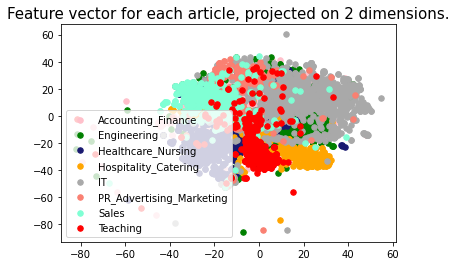

In [64]:
plotTSNE_count(df["Category"],count_features)

#### FastText

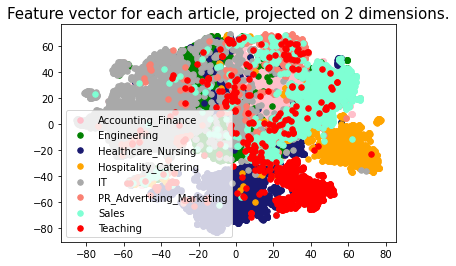

In [65]:
features =  dv_FT.to_numpy() # convert the document vector dataframe to a numpy array
plotTSNE(df["Category"],features) # plot the tSNE to have a look

#### GN300

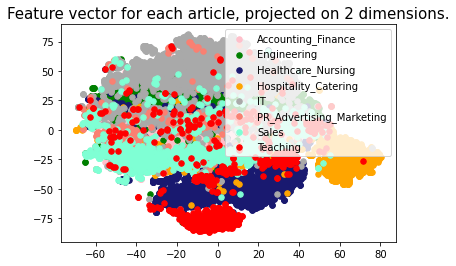

In [66]:
features =  dv_GN300.to_numpy() # convert the document vector dataframe to a numpy array
plotTSNE(df["Category"],features) # plot the tSNE to have a look

#### GLOVE

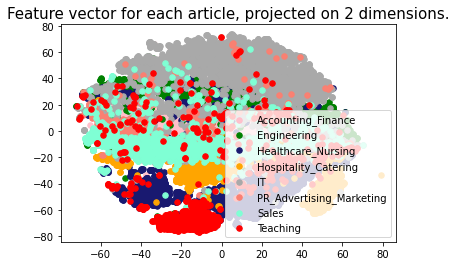

In [67]:
features =  dv_GLOVE.to_numpy() # convert the document vector dataframe to a numpy array
plotTSNE(df["Category"],features) # plot the tSNE to have a look

# Q1: Language model comparisons

We'll be using Logistic Regression as our Classification Model today.

Almost all code is the same, just that the word vectors are changed appropriately.

#### Count

In [68]:
seed = 0 # set a seed to make sure the experiment is reproducible

In [69]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


#Note: These comments apply to the similar classification code below too. I won't repeat them since they are here already.

# Splitting up the Dataset
X_train, X_test, y_train, y_test = train_test_split(count_features, df['Category'], test_size=0.33, random_state=seed)
model = LogisticRegression(random_state=seed) # Initialize Model
model.fit(X_train, y_train) # Fit (train) model with training data
model.score(X_test, y_test) # Test and get the score.

/Users/denzelo/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.8752390841029565

#### FastText

In [70]:
# creating training and test split
X_train, X_test, y_train, y_test,train_indices,test_indices = train_test_split(dv_FT, df['Category'], list(range(0,len(df))),test_size=0.33, random_state=seed)

model = LogisticRegression(max_iter = 2000,random_state=seed) # increase the max_iter to 2000 for convergence
model.fit(X_train, y_train)
model.score(X_test, y_test)

/Users/denzelo/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.8643641729056233

#### GN300

In [71]:
# creating training and test split
X_train, X_test, y_train, y_test,train_indices,test_indices = train_test_split(dv_GN300, df['Category'], list(range(0,len(df))),test_size=0.33, random_state=seed)

model = LogisticRegression(max_iter = 2000,random_state=seed) # increase the max_iter to 2000 for convergence
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.8581343242800153

#### GLOVE

In [72]:
# creating training and test split
X_train, X_test, y_train, y_test,train_indices,test_indices = train_test_split(dv_GLOVE, df['Category'], list(range(0,len(df))),test_size=0.33, random_state=seed)

model = LogisticRegression(max_iter = 2000,random_state=seed) # increase the max_iter to 2000 for convergence
model.fit(X_train, y_train)
model.score(X_test, y_test)

/Users/denzelo/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.8523416580140991

### TF-IDF Weighted Models

#### FastText Weighted

In [73]:
# creating training and test split
X_train, X_test, y_train, y_test,train_indices,test_indices = train_test_split(weighted_FT_dvs, df['Category'], list(range(0,len(df))),test_size=0.33, random_state=seed)

model = LogisticRegression(max_iter = 2000,random_state=seed) # increase the max_iter to 2000 for convergence
model.fit(X_train, y_train)
model.score(X_test, y_test)

/Users/denzelo/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.8720148642002296

#### GN300 Weighted

In [74]:
# creating training and test split
X_train, X_test, y_train, y_test,train_indices,test_indices = train_test_split(weighted_Google_dvs, df['Category'], list(range(0,len(df))),test_size=0.33, random_state=seed)

model = LogisticRegression(max_iter = 2000,random_state=seed) # increase the max_iter to 2000 for convergence
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.8639269905459315

#### GLOVE Weighted

In [75]:
# creating training and test split
X_train, X_test, y_train, y_test,train_indices,test_indices = train_test_split(weighted_GLOVE_dvs, df['Category'], list(range(0,len(df))),test_size=0.33, random_state=seed)

model = LogisticRegression(max_iter = 2000,random_state=seed) # increase the max_iter to 2000 for convergence
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.8580796764850538

### 5-Fold Cross Validation

Lets confirm our results with some awesome cross validation!

In [76]:
from sklearn.model_selection import KFold
num_folds = 5
kf = KFold(n_splits= num_folds, random_state=seed, shuffle = True) # initialise a 5 fold validation
print(kf)

KFold(n_splits=5, random_state=0, shuffle=True)


In [77]:
# Function to test performance
def evaluate(X_train,X_test,y_train, y_test,seed):
    model = LogisticRegression(random_state=seed)
    model.fit(X_train, y_train)
    return model.score(X_test, y_test)

In [78]:
# This is to remove that annoying warning that appears below
import warnings
warnings.filterwarnings('ignore')

In [79]:
num_models = 7 # Because we are comparing 7 diff models
cv_df = pd.DataFrame(columns = ['count','FastText','GN300','GLOVE','FastText Weighted',"GN300 Weighted",'GLOVE Weighted'],index=range(num_folds)) # creates a dataframe to store the accuracy scores in all the folds

fold = 0
for train_index, test_index in kf.split(list(range(0,len(category_list)))):
    y_train = [category_list[i] for i in train_index]
    y_test = [category_list[i] for i in test_index]
    
    #print(len(y_train))
    #print(len(y_test))
    
    
    # Count
    cv_df.loc[fold,'count'] = evaluate(count_features[train_index],count_features[test_index],y_train,y_test,seed)

    # FastText
    cv_df.loc[fold,'FastText'] = evaluate(dv_FT.loc[train_index],dv_FT.loc[test_index],y_train,y_test,seed)
    
    # GN300
    cv_df.loc[fold,'GN300'] = evaluate(dv_GN300.loc[train_index],dv_GN300.loc[test_index],y_train,y_test,seed)
    
    # GLOVE
    cv_df.loc[fold,'GLOVE'] = evaluate(dv_GLOVE.loc[train_index],dv_GLOVE.loc[test_index],y_train,y_test,seed)
    
    # FastText Weighted
    cv_df.loc[fold,'FastText Weighted'] = evaluate(weighted_FT_dvs.loc[train_index],weighted_FT_dvs.loc[test_index],y_train,y_test,seed)
    
    # GN300 Weighted
    cv_df.loc[fold,'GN300 Weighted'] = evaluate(weighted_Google_dvs.loc[train_index],weighted_Google_dvs.loc[test_index],y_train,y_test,seed)
    
    # GLOVE Weighted
    cv_df.loc[fold,'GLOVE Weighted'] = evaluate(weighted_GLOVE_dvs.loc[train_index],weighted_GLOVE_dvs.loc[test_index],y_train,y_test,seed)
    
    
    
    fold +=1 # To iterate 5 times (since 5 folds)

In [80]:
cv_df

,count,FastText,GN300,GLOVE,FastText Weighted,GN300 Weighted,GLOVE Weighted
0,0.87385,0.864653,0.862399,0.854914,0.871867,0.866456,0.854824
1,0.878088,0.869432,0.861858,0.856808,0.873219,0.861767,0.857529
2,0.871867,0.86835,0.861948,0.851217,0.874211,0.867268,0.853742
3,0.871867,0.866005,0.856357,0.85266,0.869973,0.858792,0.85239
4,0.872126,0.875192,0.872126,0.860402,0.880242,0.869691,0.861304


In [81]:
# Finding the means of our tests
cv_df.mean()

count                0.873559
FastText             0.868726
GN300                0.862937
GLOVE                0.855200
FastText Weighted    0.873902
GN300 Weighted       0.864795
GLOVE Weighted       0.855958
dtype: float64

### <span style='color:Blue'> **Answer: When comparing all document vectors, there are 2 document vectors that take the crown. That is:** </span>

1. Count Vector
2. FastText Weighted

Both performed the best, however it is worth noting that the difference between all 7 models was less than 3%.

# Q2: Does more information provide higher accuracy?

Good question.

Lets test that out. Before we did description only, now we'll try:
1. Title only (much shorter)
2. Title + Description (Little bit more)

## Title Only

Lets Extract the Title Only

We will only be Tokenizing the Titles for pre-processing. Read below for justification.

In [82]:
data[3]

'Title: Plant Engineer\n'

In [83]:
# Test to extract
re.findall(r'Title: (.+)\n*',data[3])

['Plant Engineer']

In [84]:
# Now extract for all titles
raw_title_list = []
for i in range(3,len(data),5):
    raw_title_list.append(re.findall(r'Title: (.+)\n*',data[i]))
    
raw_title_list[:5]

[['Plant Engineer'],
 ['Residential Care Worker'],
 ['CHEF DE RANG FOR MICHELIN STARRED RESTAURANT'],
 ['Inpatient Ward Team Leader'],
 ['Information Services Support Analyst']]

In [85]:
# Flattening the list
title_list = list(chain.from_iterable(raw_title_list))
print(len(title_list))
title_list[:5]

55449


['Plant Engineer',
 'Residential Care Worker',
 'CHEF DE RANG FOR MICHELIN STARRED RESTAURANT',
 'Inpatient Ward Team Leader',
 'Information Services Support Analyst']

#### Tokenizing the Title

Bringing back the Good'Ol tokenizer. Lets Tokenize by the special Regex pattern, since the Titles is **NOT** yet pre-processed (unlike our descriptions)

In [86]:
from nltk import RegexpTokenizer
from nltk.tokenize import sent_tokenize
from itertools import chain

# Making Tokenize function

def tokenizeReview(review):
    """
        This function first convert all words to lowercases, 
        it then segment the raw review into sentences and tokenize each sentences 
        and convert the review to a list of tokens.
    """        
    #review = raw_review.decode('utf-8') # convert the bytes-like object to python string, need this before we apply any pattern search on it
    nl_review = review.lower() # cover all words to lowercase
    
    # segament into sentences
    sentences = sent_tokenize(nl_review)
    
    # tokenize each sentence
    pattern = r"[a-zA-Z]+(?:[-'][a-zA-Z]+)?"
    tokenizer = RegexpTokenizer(pattern) 
    token_lists = [tokenizer.tokenize(sen) for sen in sentences]
    
    # merge them into a list of tokens
    tokenised_review = list(chain.from_iterable(token_lists))
    return tokenised_review

In [87]:
tk_title = [tokenizeReview(title) for title in title_list]

In [88]:
tk_title

[['plant', 'engineer'],
 ['residential', 'care', 'worker'],
 ['chef', 'de', 'rang', 'for', 'michelin', 'starred', 'restaurant'],
 ['inpatient', 'ward', 'team', 'leader'],
 ['information', 'services', 'support', 'analyst'],
 ['physiotherapist', 'cambridge'],
 ['youth', 'justice', 'officer', 'job', 'luton'],
 ['front', 'end', 'web', 'developer', 'slough', 'k', 'k'],
 ['net',
  'web',
  'developer',
  'clayton',
  'west',
  'huddersfield',
  'west',
  'yorkshire'],
 ['senior', 'account', 'manager', 'telecoms', 'it'],
 ['it', 'project', 'manager', 'c', 'aspnet', 'k', 'leicester'],
 ['cisco', 'call', 'manager', 'technician', 'greater', 'manchester'],
 ['senior', 'nurse', 'small', 'specialist', 'care', 'home'],
 ['senior', 'oracle', 'dba', 'database', 'administratornorth', 'yorkshire'],
 ['cluster', 'sales', 'manager', 'maternity', 'cover'],
 ['software', 'build', 'manager', 'msbuild'],
 ['electrical', 'fitter', 'crawley', 'sussex'],
 ['sales', 'manager', 'door', 'automation'],
 ['year', 'te

#### Note regarding 'k' and 'c':
Whilst there are random k's and c's being read as tokens, the decision was made to retain them due to it still holding significence in the meaning of that title. 

For example, most k used to be "*****k", but even though the asterisk got removed, the independent k by itself is still there, hence it can be recognized by the machine as still a placeholder for the salary. And since it is consistent throughout the corpus, there should be no issues. 

If we had removed it, then all traces of that "****k" (probably indicative of salary) will be lost, and hence information that the machine might need will be lost. A possible scenario is that Business jobs tend to put thier salary in the title, so removing it would also remove that correlation.

### <span style='color:Blue'> Note regarding further cleaning: </span>
The idea of further cleaning the titles were considered, but seeing as how short titles can be, the removing of stopwords can leave many titles severely shorter, which while it is good we removed possibly redundent information, the information leftover may be too little to help the machine learn.

## Making the Count Vector (Title Only)

We will be only using the Count Vector to test the accuracy today.
This is because:
1. The count vectors had one of the highest accuracies
2. The count vectors does not require tf-idf weighting
3. The count vectors does not require word embedding to vectors

As an intelligent Data Scientist, why would you spend so much more time doing a model that is identical in performance but takes significently longer time?

Also, if the goal is to investigate if more information give better accuracy, as long as we compare the same model, it is relative, and we can achieve our goal without wasting unnessecery time and resources!

In [89]:
# Making our vocab list
words_title = list(chain.from_iterable(tk_title)) # we put all the tokens in the corpus in a single list
vocab_title = set(words_title) # compute the vocabulary by converting the list of words/tokens to a set, i.e., giving a set of unique words
vocab_list_title = list(vocab_title)

In [90]:
# Initialize the count vectorizer
cVec = CountVectorizer(analyzer = "word", vocabulary=vocab_list_title)

In [91]:
# This is where the count vectorizing occurs
count_features_title = cVec.fit_transform([text for text in title_list])
count_features_title.shape

(55449, 10858)

### Graph (Title Only)

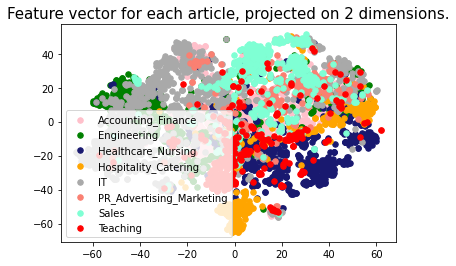

In [92]:
# Making sure to use our speical B.O.W TSNE function
plotTSNE_count(df["Category"],count_features_title)

### Classification (Title Only)

In [93]:
# Classification with 5 K-Folds cross validation

num_models = 1 # 1 model cause we only have Title Only
cv_df_title = pd.DataFrame(columns = ['count (title only)'],index=range(num_folds)) # creates a dataframe to store the accuracy scores in all the folds

fold = 0
for train_index, test_index in kf.split(list(range(0,len(category_list)))): # K-fold function helping us split the Data
    y_train = [category_list[i] for i in train_index] # Creating our y train/test based on the splits
    y_test = [category_list[i] for i in test_index]
    
    # Count (title only)
    cv_df_title.loc[fold,'count (title only)'] = evaluate(count_features_title[train_index],count_features_title[test_index],y_train,y_test,seed)
    # Allocating the cell in the DataFrame the score of the model
    
    fold +=1


In [94]:
cv_df_title

,count (title only)
0,0.839585
1,0.841659
2,0.83697
3,0.838233
4,0.844711


In [95]:
cv_df_title.mean()

count (title only)    0.840232
dtype: float64

## Title + Description (All)

We will now concatenate the Title and Description, trying to get the "most information" we can.

This is because the Title and the Description should be very related, hence thier vectors should be calculated togather.


In [96]:
# Making list of strings where:
# Each string is the Title + Description combined
both_list_raw = []

for i in range (0,len(des)):
    both_list_raw.append(title_list[i].lower() + ' ' + des[i]) # Lowercase the titles is all we need

In [97]:
tk_all = [tokenizeReview(text) for text in both_list_raw]

#### Making count vector

In [98]:
# Making our vocab list
words_all = list(chain.from_iterable(tk_all)) # we put all the tokens in the corpus in a single list
vocab_all = set(words_all) # compute the vocabulary by converting the list of words/tokens to a set, i.e., giving a set of unique words
vocab_list_all = list(vocab_all)

In [99]:
# Initialize the count vectorizer
cVec = CountVectorizer(analyzer = "word", vocabulary=vocab_list_all)

In [100]:
# This is where the count vectorizing occurs
count_features_all = cVec.fit_transform([text for text in both_list_raw])
count_features_all.shape

(55449, 42487)

### Graph (All)

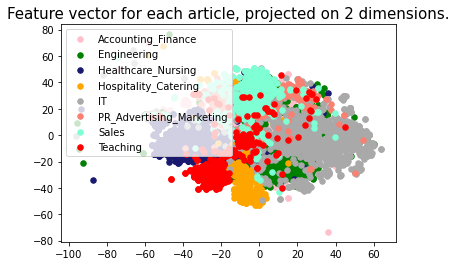

In [101]:
plotTSNE_count(df["Category"],count_features_all)

### Classification (All)

In [102]:
# Doing the Classification now
num_models = 1 # 1 model since we only have 1 vector
cv_df_all = pd.DataFrame(columns = ['count (Title + Des)'],index=range(num_folds)) # creates a dataframe to store the accuracy scores in all the folds

fold = 0
for train_index, test_index in kf.split(list(range(0,len(category_list)))): # K folds splitting the data for us
    y_train = [category_list[i] for i in train_index] # Y Train/test based on k folds
    y_test = [category_list[i] for i in test_index]
    

    # Count (title only)
    cv_df_all.loc[fold,'count (Title + Des)'] = evaluate(count_features_all[train_index],count_features_all[test_index],y_train,y_test,seed)
    # Allocating the cell in the DataFrame the score of the model
    
    fold +=1
cv_df_all

,count (Title + Des)
0,0.879711
1,0.880433
2,0.878539
3,0.875564
4,0.878889


In [103]:
cv_df_all.mean()

count (Title + Des)    0.878627
dtype: float64

Wow... Much better than Titles Only.

Lets **Compare** all 3 now:

In [104]:
# Description Only

print('Description Only:')
print(cv_df['count'].mean())
cv_df['count']

Description Only:
0.8735594612358847


0     0.87385
1    0.878088
2    0.871867
3    0.871867
4    0.872126
Name: count, dtype: object

In [105]:
# Title Only

print('Title Only:')
print(cv_df_title['count (title only)'].mean())
cv_df_title

Title Only:
0.8402316449229007


,count (title only)
0,0.839585
1,0.841659
2,0.83697
3,0.838233
4,0.844711


In [106]:
# Title + Description

print('Title + Description:')
print(cv_df_all['count (Title + Des)'].mean())
cv_df_all

Title + Description:
0.8786272117040411


,count (Title + Des)
0,0.879711
1,0.880433
2,0.878539
3,0.875564
4,0.878889


In [107]:
# New DataFrame showing all togather
df_combined = pd.DataFrame(columns = ['Des','Title','Both'])
df_combined["Des"] = cv_df['count']
df_combined["Title"] = cv_df_title['count (title only)']
df_combined["Both"] = cv_df_all['count (Title + Des)']


In [108]:
# Showing all
print(df_combined.mean())
df_combined

Des      0.873559
Title    0.840232
Both     0.878627
dtype: float64


,Des,Title,Both
0,0.87385,0.839585,0.879711
1,0.878088,0.841659,0.880433
2,0.871867,0.83697,0.878539
3,0.871867,0.838233,0.875564
4,0.872126,0.844711,0.878889


In [110]:
0.878627/0.840232 * 100

104.56957126127071

Aha! We can clearly see that the Title + Description model is the best performing! Followed by the Description only, then the Titles only.

If we look at relative scale:

- Title: 100%
- Description: 103.97%
- Both: 104.57%



### <span style='color:Blue'> **Answer: We can take this as evidence that more information (in terms of words) does in fact lead to better accuracy in prediction with classification.**

## Summary

In summary, this task was comprised of 3 main sub tasks:

1. Create Document Vectors
2. Assess thier performance in a Classification Model
3. Investigate if more information led to higher performance

A highlight of this assignment was altering the document vectoring function for speed. The output was checked to be identical as the original, but the processing was significently faster. I have learnt that sometimes for massive calculations, using rudimentary tools like Arrays rather than fancier Dataframes can have HUGE impacts on speed and computational resources.

In terms of the questions:
Q1: It is conclusive that the Count Vector and Weighted FastText Vectors performed the best.
Q2: We can conclude that more information fed into the document vectors does inherently lead to performance gains.

I enjoyed doing this project, and felt I have learnt alot from it. 

Thanks for reading! Hope you enjoyed it!


## Couple of notes for all code blocks in this notebook
- please provide proper comment on your code
- Please re-start and run all cells to make sure codes are runable and include your output in the submission.   
<span style="color: red"> This markdown block can be removed once the task is completed. </span>